In [320]:
import torch
import importlib
import random
import noise
import numpy as np
import matplotlib.pyplot as plt
import src.generate_env as gen_env
from scipy.stats import uniform
from scipy.stats import levy_stable
importlib.reload(gen_env)
import src.physics as physics
importlib.reload(physics)
import src.EINCASMConfig as EINCASMConfig
importlib.reload(EINCASMConfig)

cfg = EINCASMConfig.Config('config.yaml')

num_scents = cfg.num_resource_types
perception_indecies = {
    "scent": [i for i in range(0, num_scents)],
    "capital": [i for i in range(num_scents, num_scents + cfg.kernel.shape[0])],
    "muscles": [i for i in range(num_scents + cfg.kernel.shape[0], num_scents + cfg.kernel.shape[0]*2)],
    "communication": [i for i in range(num_scents + cfg.kernel.shape[0]*2, num_scents + cfg.kernel.shape[0]*2 + cfg.num_communication_channels)]
}

actuator_indecies = {
    "growth_activation": [i for i in range(cfg.kernel.shape[0])], # Flow muscles for kernel + mine + resource muscles
    "communication": [i for i in range(cfg.kernel.shape[0], cfg.kernel.shape[0]+cfg.num_communication_channels)],
    "flow_activation": cfg.kernel.shape[0]+cfg.num_communication_channels,
    "mine_activation": cfg.kernel.shape[0]+cfg.num_communication_channels+1,
    "resource_activation": cfg.kernel.shape[0]+cfg.num_communication_channels+2
}
perception_indecies, actuator_indecies

({'scent': [0, 1, 2],
  'capital': [3, 4, 5, 6, 7],
  'muscles': [8, 9, 10, 11, 12],
  'communication': [13, 14, 15, 16, 17]},
 {'growth_activation': [0, 1, 2, 3, 4],
  'communication': [5, 6, 7, 8, 9],
  'flow_activation': 10,
  'mine_activation': 11,
  'resource_activation': 12})

Channel range: 0.0 to 1.0


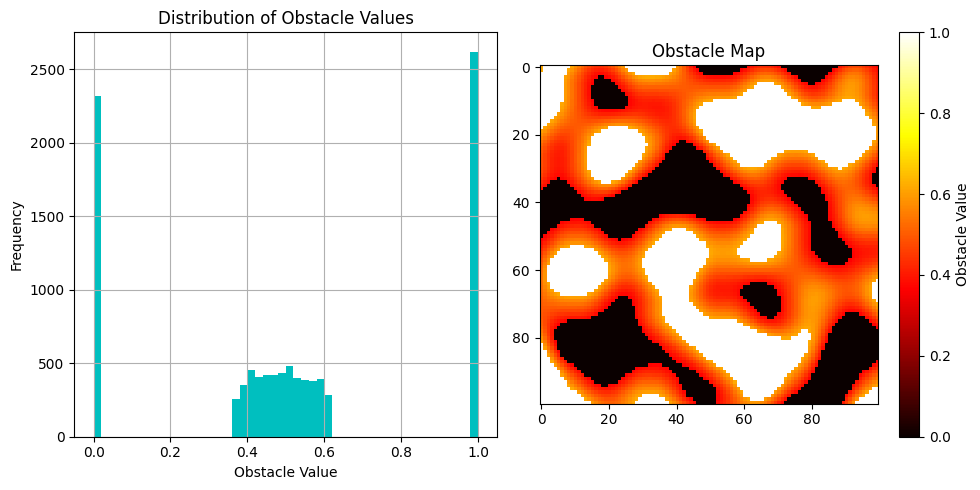

obstacle range: 0.0 - 1.0


In [330]:
obstacles = np.zeros(cfg.world_shape)
obstacles = gen_env.populate_obstacle(obstacles)
obstacles = torch.from_numpy(obstacles).float()

fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(obstacles.flatten(), bins=50, color='c')
axs[0].set_title('Distribution of Obstacle Values')
axs[0].set_xlabel('Obstacle Value')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

im = axs[1].imshow(obstacles, cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=axs[1], label='Obstacle Value')
axs[1].set_title('Obstacle Map')

plt.tight_layout()
plt.show()

print(f"obstacle range: {obstacles.min()} - {obstacles.max()}")


# Weather

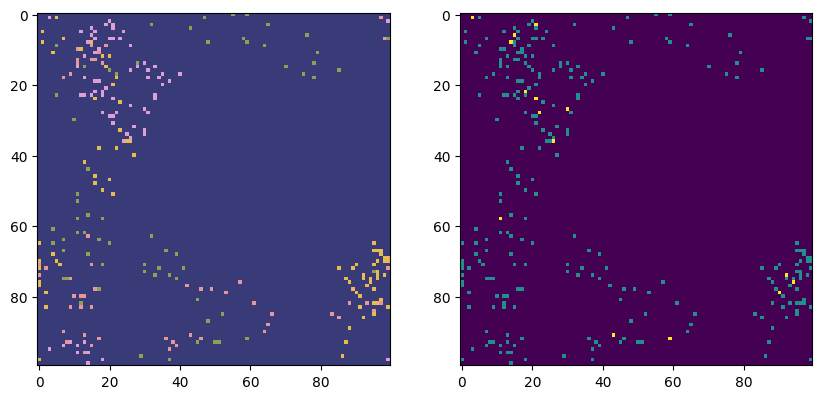

In [98]:
import matplotlib


class Resource:
    # a resource as an id (incremental), a min and max,
    # regeneration and dispersal functions of time,
    # a distribution function (levy dust usually)

    # a resource exists in the resource map as an id on a given cell along with a value
    # the id determines how to update it using the respective functions in this class

    def __init__(self, id, min, max, regen_func, dispersal_func):
        self.id = id
        self.min = min
        self.max = max
        self.regen_func = regen_func
        self.dispersal_func = dispersal_func
        
        self.alpha = random.uniform(0.8, 1.2)
        self.beta = random.uniform(0.8, 1.2)
        self.num_sites = random.randint(50, 100)


    def update_distribution_params(self, alpha, beta, num_sites):
        self.alpha = alpha
        self.beta = beta
        self.num_sites = num_sites
    

    def discretize_levy_dust(self, shape: tuple, dust: np.array) -> np.array:
        """Discretize a levy dust cloud into a grid of shape shape,
        such that each position in the grid is the number of points in the cloud that fall in that position

        Returns:
            np.array: Grid of shape shape representing the density of points in the dust cloud
        """
        dust = np.array(dust, dtype=np.int64)
        points, density = np.unique(dust, axis=1, return_counts=True)
        out = np.zeros(shape)
        out[points[0,:], points[1,:]] = torch.from_numpy(density).float()
        return out

    def levy_dust(self, shape: tuple, points: int, alpha: float, beta: float) -> np.array:
        angle = uniform.rvs(size=(points,), loc=.0, scale=2.*np.pi) 

        # Ensure alpha and beta are within the valid range for the levy_stable distribution
        alpha = max(min(alpha, 2), 0.1)
        beta = max(min(beta, 1), -1)

        step_length = abs(levy_stable.rvs(alpha, beta, size=points))

        x = np.cumsum(step_length * np.cos(angle)) % (shape[0])
        y = np.cumsum(step_length * np.sin(angle)) % (shape[1])

        return np.array([x, y])

    def populate_map(self, resource_map, port):
        dust = self.levy_dust(port.shape, self.num_sites, self.alpha, self.beta)
        dust = self.discretize_levy_dust(port.shape, dust)
        port += dust
        resource_map[dust > 0] = self.id

        return resource_map, port

    def update(self, time, resource_map, port):
        port[resource_map == self.id] = torch.clamp(port[resource_map == self.id] + self.regen_func(time), self.min, self.max)


def gen_random_signal_func(num_components=4,
                        min_freq=np.pi/10, max_freq=np.pi*3, min_amp=1, max_amp=1,
                        min_start_period=0, max_start_period=np.pi*2):

    freqs = (max_freq - min_freq) * torch.rand(num_components) + min_freq
    # rots = (max_rot - min_rot) * torch.rand(num_signals).to(device) + min_rot
    amps = (max_amp - min_amp) * torch.rand(num_components) + min_amp
    start_periods = (max_start_period - min_start_period) * torch.rand(num_components) + min_start_period

    return lambda t: sum([amps[i] * torch.sin(freqs[i] * t + start_periods[i]) for i in range(num_components)])

resource_map = torch.zeros(cfg.world_shape, dtype=torch.int8)
port = torch.zeros(cfg.world_shape, dtype=torch.float32)

resources = []
num_resources = 4
for i in range(1,num_resources+1):
    resources.append(Resource(i, 0, 10, gen_random_signal_func(), gen_random_signal_func()))
    resource_map, port = resources[i-1].populate_map(resource_map, port)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(resource_map, cmap="tab20b")
ax[1].imshow(port)
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation

num_iters = 100

fig, ax = plt.subplots(1,2, figsize=(10,5))

def update(i):
    for resource in resources:
        resource.update(i, resource_map, port)
    ax[0].cla()
    ax[1].cla()
    ax[0].imshow(resource_map, cmap="tab20b")
    ax[1].imshow(port)

ani = FuncAnimation(fig, update, frames=num_iters, repeat=False)
plt.show()

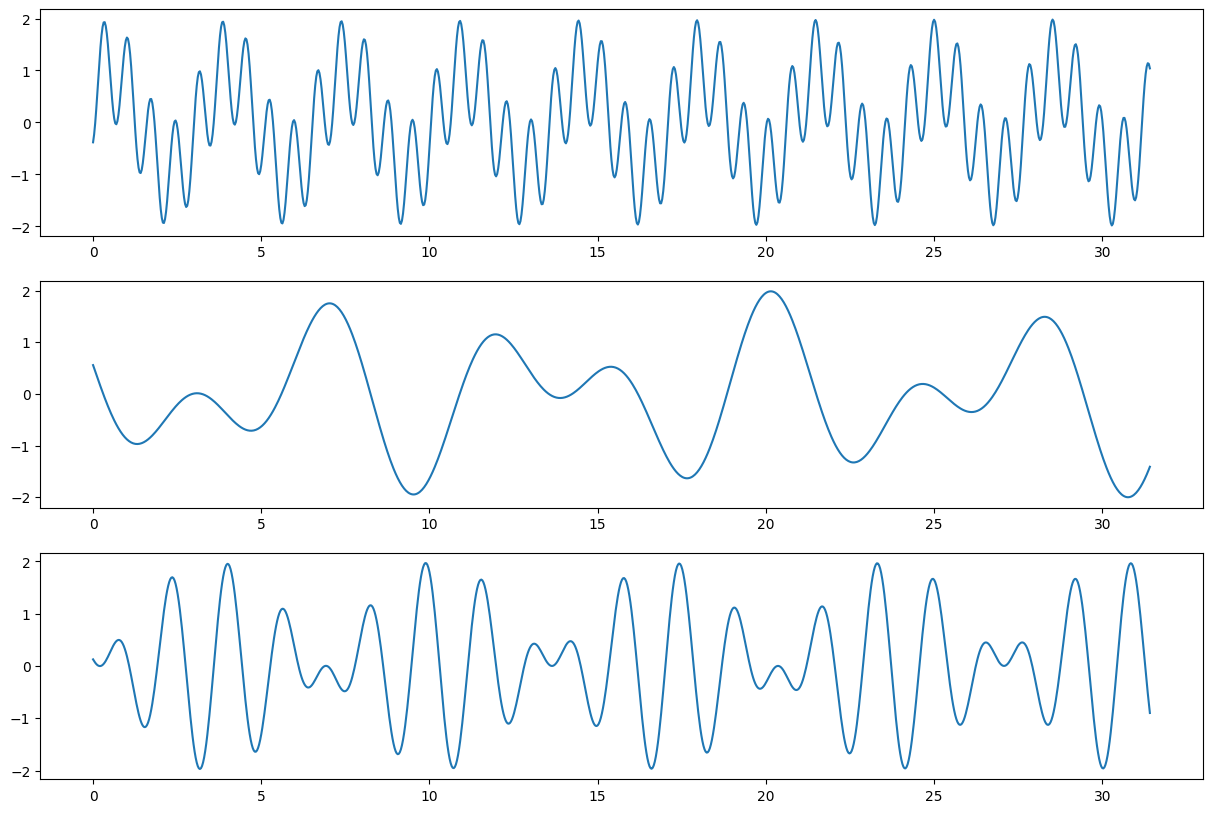

In [257]:
import matplotlib.pyplot as plt

num_signals_to_plot = 2
t = torch.linspace(0, np.pi*10, steps=1000)

signal_funcs = [gen_random_signal_func(num_components=num_signals_to_plot) for _ in range(3)]

fig, axs = plt.subplots(3,1, figsize=(15, 10))
for i, signal_func in enumerate(signal_funcs):
    axs[i].plot(t, signal_func(t))

plt.show()
